In [2]:
import pandas as pd
import csv
import numpy as np
from tqdm import tqdm

In [ ]:
# quick check at the current working directory
import os

print(os.getcwd())

parent_path = os.getcwd() # setting up a waypoint to comeback

In [4]:
# defining the dataset path wrt to the cwd

ds_path = r'C:\Users\jaish\OneDrive\Desktop\Stuff\College\Capstone_Project\Dataset\DATA' # thy must replace with thine path
sector_ls = os.listdir(ds_path)
print(sector_ls)

['agriculture', 'buildings', 'fluorinated_gases', 'forestry_and_land_use', 'fossil_fuel_operations', 'IND_geometries.gpkg', 'manufacturing', 'mineral_extraction', 'power', 'transportation', 'waste']


In [5]:
sector_ls.remove('IND_geometries.gpkg') # removing this little shit cause it ain't a CSV file

# moving to the dataset directory cause why not
os.chdir(ds_path)

# var that stores sector-wise filenames of the ones needed
necces_files = {}

for sector in sector_ls:
    
    # path for files from root
    sector_path = os.path.join(ds_path, sector)
    
    file_list = os.listdir(sector_path)
    
    # we're using the '*_country_emmisions.csv' files only, so ditch the rest
    filtered_sector_files = [file for file in file_list if file.endswith('_country_emissions.csv')]
    
    necces_files[sector] = filtered_sector_files

In [5]:
print(necces_files)

{'agriculture': ['cropland-fires_country_emissions.csv', 'enteric-fermentation-cattle-feedlot_country_emissions.csv', 'enteric-fermentation-cattle-pasture_country_emissions.csv', 'enteric-fermentation-other_country_emissions.csv', 'manure-left-on-pasture-cattle_country_emissions.csv', 'manure-management-cattle-feedlot_country_emissions.csv', 'manure-management-other_country_emissions.csv', 'other-agricultural-soil-emissions_country_emissions.csv', 'rice-cultivation_country_emissions.csv', 'synthetic-fertilizer-application_country_emissions.csv'], 'buildings': ['other-onsite-fuel-usage_country_emissions.csv', 'residential-and-commercial-onsite-fuel-usage_country_emissions.csv'], 'fluorinated_gases': ['fluorinated-gases_country_emissions.csv'], 'forestry_and_land_use': ['forest-land-clearing_country_emissions.csv', 'forest-land-degradation_country_emissions.csv', 'forest-land-fires_country_emissions.csv', 'net-forest-land_country_emissions.csv', 'net-shrubgrass_country_emissions.csv', 'n

# Data Preprocessing

## &ensp;1. Data Combining :

&emsp;The model will be trained at sector level, hence the datasets **within** the sector will be **combined**.


In [6]:
from tqdm import tqdm
import pandas as pd

# Loop through sectors and their respective files
for sector, files in dict.items(necces_files):
    combined_df = pd.DataFrame()
    
    # Iterating through the sector files
    for file in tqdm(files):
        
        # Reading individual CSV files with the needed 
        sector_df = pd.read_csv(
            f"{ds_path}\{sector}\{file}",
            usecols=['start_time', 'end_time', 'gas', 'emissions_quantity', 'emissions_quantity_units']
        )
        
        # Formatting the columns to retain only the dates
        sector_df['start_time'] = pd.to_datetime(sector_df['start_time']).dt.date
        sector_df['end_time'] = pd.to_datetime(sector_df['end_time']).dt.date
        
        # Combine the dataframes
        combined_df = pd.concat([combined_df, sector_df], ignore_index=True)
    
    # Group by 'start_time' and 'gas' to average the emissions_quantity
    # This done because the sub-sector datasets include same start_times and the gases that being recorded
    combined_df = (
        combined_df.groupby(['start_time', 'gas'], as_index=False)
        .agg({'emissions_quantity': 'mean'})
    )
    
    # Save the combined and processed dataframe
    combined_df.to_csv(f"{ds_path}\{sector}\sector_combined.csv")


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 74.93it/s]


## &ensp;2. Data Preprocessing :

&emsp;Now that the sector-wise data has been combined to a singular file, the data needs to be processed and handled before it can be used for training the model.

Following is the schema that all the *sector-combined* datasets conform to - 

![Schema of the datasets](schema.png)

Given how the time interval is **yearly** and the 5 gases seen in the image are what are tracked, the dataset will have to be modified to the following schema - 

| start_time | ch4 | co2 | co2e_100yr | co2e_20yr | n2o |
| ---------- | --- | --- | ---------- | --------- | --- |

### Reasons behind doing this - 

1. SARIMA/ARIMA models require time-series data that have **consistent** intervals. Thus, _start_time_ column provides information regarding the time intervals and since the intervals are consistently on a yearly basis, *end_time* column will not provide any additional context that *start_time* would not.
    1. SARIMA/ARIMA are being used as a part of a comparative analysis with other models. While the other models don't explicitly specify the need for stationarity, it doesn't harm to make the data stationary.
2. Since the task/objective is to forecast emissions of gases and these 5 gases are consistently tracked it is only apt to make them the column heads.


In [7]:
# Modifying the 'sector_combined' CSV files to conform to the new schema.

import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Iterate through every sector and format the sector-combined dataset
for sector in tqdm(sector_ls):
    
    # Load dataset
    file_path = f"{ds_path}\{sector}\sector_combined.csv"
    data = pd.read_csv(file_path)
    
    # Replace inf with NaN
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # Reformating the dataset as per the schema
    pivoted_df = data.pivot(index='start_time', 
                     columns='gas', 
                     values='emissions_quantity')
    
    for col in pivoted_df.columns:
        
        if pivoted_df[col].isna().all(): # the entire column contains NaN values, drop that col.
            del pivoted_df[col]
        
        else:
            
            # interpolation to fill NaN values
            pivoted_df[col] = pivoted_df[col].interpolate(method='linear')
    
    # Replacin with the formatted dataset
    pivoted_df.to_csv(file_path)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 70.99it/s]


### Results of reformatting - 

![Formatted dataset](sample.png)

**Note**: The attached image is actually the entire available dataset for one of the images. No kidding. 

While the dataset may seem small, given the nature of SARIMA models, it is still good enough for a model to be trained as the time-interval is every 1 year given the model 9 trends to predict and understand patterns in seasonality. Good enough ig.

However, just to be sure, I shall perform Augmented Dickey-Fuller (ADF) test to check for stationarity and, if necessary, apply transformations (e.g., differencing) to make the data stationary. This is to be done as SARIMA models require data to **stationary** - mean and variance do not change over time.

In [11]:
# Performing ADF test to check for stationarity

import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Helper function to perform ADF test
def perform_adf_test(time_series):
    result = adfuller(time_series.dropna())
    adf_statistic = result[0]
    p_value = result[1]
    critical_values = result[4]
    
    # Print them results in a neat way
    print(f'ADF Statistic: {adf_statistic}')
    print(f'p-value: {p_value}')
    print(f'Critical Values: {critical_values}')
    print('-' * 40)
    
    return p_value

# Random var to store results.
sec_ds_interpets = {}
stat = False # boolean for when the ds is stationary
d_count = 0 # var to count the order fo diff needed to make the data stationary

# Iterative loading
for sector in tqdm(sector_ls):
    
    sec_ds_interpets[sector] = []
    
    # Load dataset
    file_path = f"{ds_path}\{sector}\sector_combined_daily.csv"
    data = pd.read_csv(file_path)
    data.set_index('start_time', inplace=True)
    
    # Loop through each time-series column in the dataset and perform the ADF test. 
    # Time-series columns are [ch4, co2, co2e_100yr, co2e_20yr, n2o] 
    for column in data.columns:
        
        # some columns for some sector-datasets have a mean of 0. Remove these columns ig.
        # Additional preprocessing - skip col if it contains constants
        
        if data[column].nunique() == 1:
            result = f"Column '{column}' contains a single unique value: {data[column].iloc[0]}. Skipped this column."
        
        else:
            print(f'Performing ADF test for {column}...')
            p_value = perform_adf_test(data[column])

            # Interpretation
            if p_value < 0.05:
                result = f"{column} is likely stationary (p-value < 0.05)."
                print(result)
            else:
                result = f"{column} is likely non-stationary (p-value >= 0.05). Applying differencing..."
                print(result)
                
                # Apply differencing
                data[column] = data[column].diff()  # Apply first differencing
                
                # Re-run the ADF test after differencing
                print(f'Performing ADF test after differencing for {column}...')
                p_value_diff = perform_adf_test(data[column])
                
                # Interpretation after differencing
                if p_value_diff < 0.05:
                    result = f"{column} is stationary after differencing (p-value < 0.05)."
                else:
                    result = f"{column} is still non-stationary after differencing (p-value >= 0.05). Consider further transformations."
        
        sec_ds_interpets[sector].append(result)
        print('\n')

        
# Identifying da keys where all variables are deemed stationary
stationary_keys = [
    key for key, values in sec_ds_interpets.items()
    if all('stationary (p-value < 0.05)' in value for value in values)
]

print("Keys where all variables are stationary:", stationary_keys)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 83.98it/s]

Performing ADF test for ch4...
ADF Statistic: -0.42460359436859324
p-value: 0.9059091030374502
Critical Values: {'1%': -4.9386902332361515, '5%': -3.477582857142857, '10%': -2.8438679591836733}
----------------------------------------
ch4 is likely non-stationary (p-value >= 0.05). Applying differencing...
Performing ADF test after differencing for ch4...
ADF Statistic: -3.2704601000786933
p-value: 0.016251662992095062
Critical Values: {'1%': -5.354256481481482, '5%': -3.6462381481481483, '10%': -2.901197777777778}
----------------------------------------


Performing ADF test for co2...
ADF Statistic: -84.56414042955582
p-value: 0.0
Critical Values: {'1%': -6.045114, '5%': -3.9292800000000003, '10%': -2.98681}
----------------------------------------
co2 is likely stationary (p-value < 0.05).


Performing ADF test for co2e_100yr...
ADF Statistic: -0.2381741790896723
p-value: 0.9338157371313154
Critical Values: {'1%': -4.9386902332361515, '5%': -3.477582857142857, '10%': -2.84386795918

#### Given how the data is not stationary, differencing needs to be applied for both seasonal and non-seasonal trends.

Prior to that, the dataset needs to be expanded such that more sample are present. The **8 rows** of data ain't enough to train any model. 

Thus to address this need, the dataset will be **resampled with a higher frequency**. The current data has the **temporal granularity** of **annual**. 

This means that the frequency is **annual** giving us 8 rows of numerical data and that the data recorded for each year or each instance of data is the **aggregated value** of emmissions for the **entire** year. Mathematically - 

$$\sum_{x = 1}^{365}{Daily Emmission}$$

To be honest the ideal way is to perform rigrous research about the sectors and their sources to identify aspects of **seasonality trends** that may need to be considered or would be helpful when repopulating the dataset with a higher temporal frequency. 

###### However, given the time constraint I'm posed with at the time of building this project as a Degree requirement and the outstanding selection methodologies adopted by the faculty when it came to teams for these Capstone projects, I've been blessed with teammates who pull a Houdini when tasked, I have no choice but to adopt the following to address the issue with increasing temporal frequency.

### The Method - 

$${\frac{X}{365}}$$

Where X is the instance of data. For the sake of simplicity, I've ignored the fact of leap years having 366 days.

With the data instances now being an **approximate of the possible daily emmission values**, resampling can be done in the order - Monthly, Weekly, and then Daily - ensuring some noise is introduced at each step to prevent models from over-generalizaion.



In [13]:
import pandas as pd 
import numpy as np 
from tqdm import tqdm

for sector in tqdm(sector_ls):
    # File paths
    input_file_path = f"{ds_path}\{sector}\sector_combined.csv"
    output_file_path = f"{ds_path}\{sector}\sector_combined_formatted.csv"

    try:

        df = pd.read_csv(input_file_path, parse_dates=['start_time'])

        # Set the date as index
        df.set_index('start_time', inplace=True)

        # CHeck if one of the columns has only '0' as value. If so, purge that col. - would raise error when invoking THE method

        for col in df.columns:

            if (df[col]==0).all():
                df.drop(col, axis=1, inplace=True) # 0 for dropping rows and 1 for columns


        # Implementing the mother of all methods - dividing the instances by 365 to get an approx. daily emmission val

        df = df.astype(float)/365 # Just in case it does not load as a float-type

        #print(df)

        df.to_csv(output_file_path)

    except Exception as e:
        print(f"Error processing {sector}: {e}")
        


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 239.49it/s]


In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# Helper function to add random noise
def add_noise(value, noise_level=0.05):
    try:
        return value + np.random.normal(0, abs(noise_level * value))
    except:
        return value  # return original value if adding noise fails

for sector in tqdm(sector_ls):
    # File paths
    input_file_path = f"{ds_path}\{sector}\sector_combined_weekly.csv" # sector_combined_weekly.csv , sector_combined_formatted.csv , sector_combined_monthly.csv
    output_file_path = f"{ds_path}\{sector}\sector_combined_daily.csv"

    try:
  
        df = pd.read_csv(input_file_path, parse_dates=['start_time'])

        # Set the date as index
        df.set_index('start_time', inplace=True)
        
        
        # 3 iterations - monthly resample then weekly then daily
        #df_mon = df.resample('M').mean()
        #df_w = df.resample('W').mean()
        df_d = df.resample('D').mean()

        # Fill missing values with forward fill
        df_d.fillna(method='ffill', inplace=True)

        df_d.to_csv(output_file_path)

        # reloading resampled data and add noise cause it aint workin without
        df_with_noise = pd.read_csv(output_file_path, index_col=0)
        df_with_noise = df_with_noise.applymap(lambda x: add_noise(x, noise_level=0.05))

        # Save the updated data with noise
        df_with_noise.to_csv(output_file_path)

    except Exception as e:
        print(f"Error processing {sector}: {e}")


In [18]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_sector_data(sector_ls, ds_path):
    """
    Plots all columns (e.g., gases) for each sector on a single figure with subplots.

    Parameters:
        sector_ls (list): List of sectors (folder names) to process.
        ds_path (str): Path to the directory containing the sector CSV files.
    """
    # Number of sectors
    n_sectors = len(sector_ls)
    
    # Create subplots with a grid layout
    fig, axes = plt.subplots(n_sectors, 1, figsize=(12, 6 * n_sectors), sharex=True)
    
    # Ensure axes is iterable even if there's only one sector
    if n_sectors == 1:
        axes = [axes]

    for i, sector in enumerate(sector_ls):
        try:
            # Loading the resampled dataset for the sector
            file_path = f"{ds_path}\{sector}\sector_combined_daily.csv"
            df = pd.read_csv(file_path, parse_dates=['start_time'], index_col='start_time')
            
            # Plot each column (gas) on the same subplot
            for column in df.columns:
                axes[i].plot(df.index, df[column], label=column)

            # Subplot customization
            axes[i].set_title(f"{sector.capitalize()} Emissions Over Time", fontsize=14)
            axes[i].set_ylabel("Emission / Metric Tonnes", fontsize=12)
            axes[i].legend(loc='upper left', fontsize=10)
            axes[i].grid(True)
        
        except Exception as e:
            print(f"Error processing {sector}: {e}")
            axes[i].set_title(f"{sector.capitalize()} (Error Loading Data)", fontsize=14)

    # Shared X-axis customization
    axes[-1].set_xlabel("Time", fontsize=12)

    # Adjust layout
    plt.tight_layout()
    plt.show()


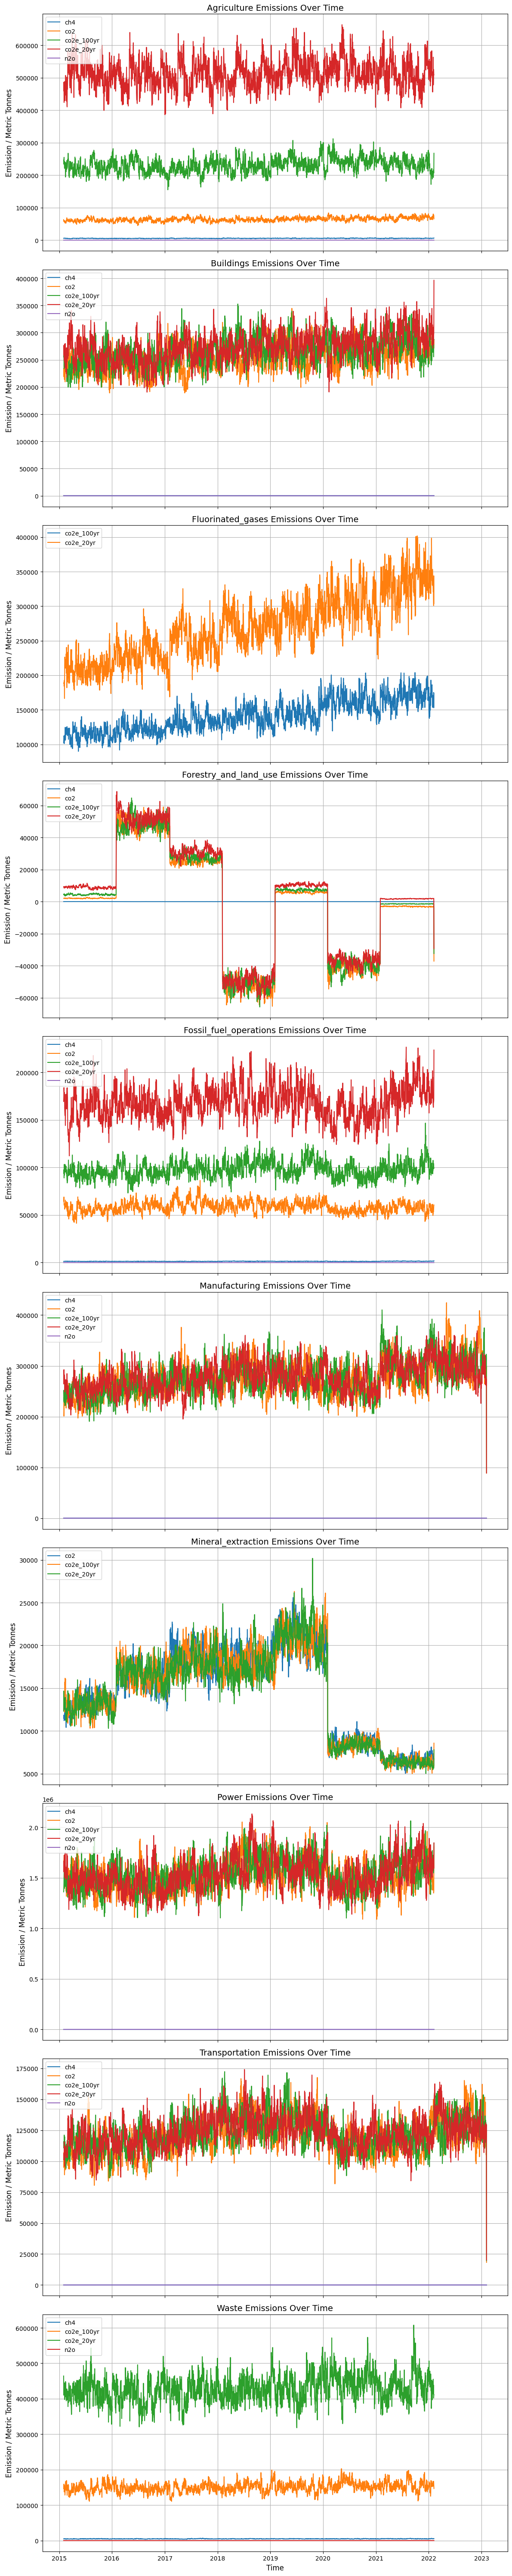

In [19]:
plot_sector_data(sector_ls, ds_path)

#### The plots for the gases that seem like they have emissions value = 0, is actually them having have relatively small value compared to the other gases plotted in the same plot.